In [106]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = None

In [107]:
loan_data_processed_backup = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_16756\87031763.py:1: DtypeWarning: Columns (21,49) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data_processed_backup = pd.read_csv(r'D:\Datasets\LendingClub\loan_data_processed.csv')


In [108]:
loan_data_processed = loan_data_processed_backup.copy()

In [109]:
# LGD = percoentage of exposure that was lost after the borrower defaulted
# EAD = amount of exposure at the moment the borrower defaulted

In [110]:
# when building LGD and EAD models it is good practice to build models with data 
# from borrowers that have had enough time to repay part of the remaining debt

# eg.g loan_status = "Charged Off" or 'Does not meet the credit policy'

In [111]:
loan_data_processed['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [112]:
loan_data_processed['good_bad'] = np.where(loan_data_processed['loan_status'].isin(['Charged Off',
                                                               'Defeault',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

In [113]:
loan_data_defaults = loan_data_processed[loan_data_processed['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])]

In [114]:
print("% Proportion Defaulted accounts: ", np.round(loan_data_defaults.shape[0] / loan_data_processed.shape[0] * 100, 2))

% Proportion Defaulted accounts:  9.27


In [115]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1                                                           0
Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                         

### Independent variables

In [116]:
# for LGD and EAD models, the independent variables do not need to be solely dummies
# we will include the below as continuous
# but we have to fill in missing values

# mths_since_last_delinq
# mths_since_last_record    

# if risk modelling, take the most conservative route
loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_16756\733665988.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
C:\Users\User\AppData\Local\Temp\ipykernel_16756\733665988.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['mths_since_last_record'].fillna(0, inplace = True)


### Dependent variables

In [117]:
# LGD = % exposure not recovered (1 - recovery rate)

loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

C:\Users\User\AppData\Local\Temp\ipykernel_16756\1164199358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']


In [118]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

In [119]:
# truncate > 1 to 1
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

C:\Users\User\AppData\Local\Temp\ipykernel_16756\2075275155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
C:\Users\User\AppData\Local\Temp\ipykernel_16756\2075275155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])


In [120]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

In [121]:
# exposure at default (EAD) = maximum that bank may lose when borrower defaults on a loan
# EAD = funded amount outstanding at default
# EAD = total funded amount x credit conversion factor
# CCF = % of total exposure at default
# EAD = CCF * funded amount
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

C:\Users\User\AppData\Local\Temp\ipykernel_16756\4131228371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']


In [122]:
# CCF = 0 means all paid
# CCF = 1 nothing has been paid
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

### Explore Dependent Variables

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

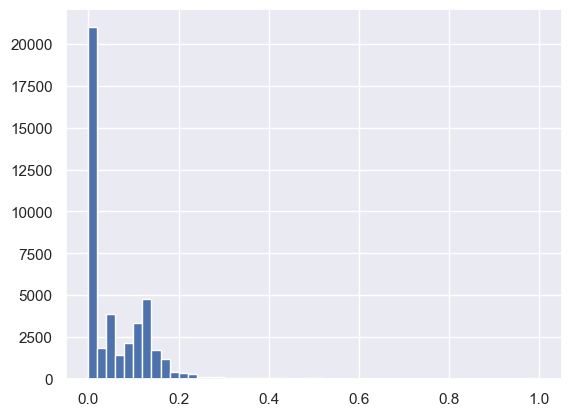

In [124]:
plt.hist(loan_data_defaults['recovery_rate'], bins=50)

(array([  20.,   60.,   29.,   97.,   70.,   84.,  150.,   78.,  124.,
         170.,  152.,  208.,  199.,  228.,  242.,  276.,  300.,  335.,
         339.,  376.,  412.,  421.,  505.,  505.,  575.,  583.,  614.,
         735.,  756.,  812.,  840.,  942.,  959., 1137., 1217., 1418.,
        1431., 1580., 1732., 1850., 2003., 2151., 2123., 2376., 2447.,
        2693., 2366., 2115., 1527.,  874.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

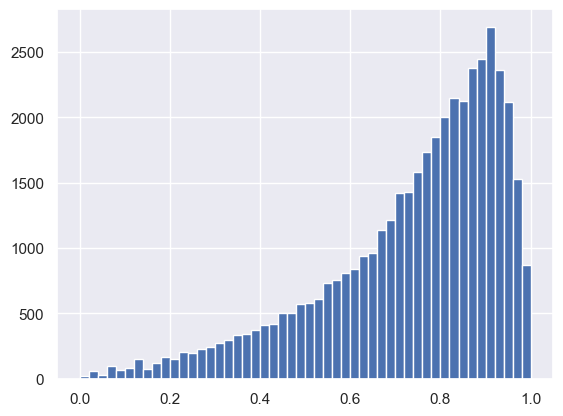

In [125]:
# CCF = 0 means all paid
# CCF = 1 nothing has been paid

plt.hist(loan_data_defaults['CCF'], bins=50)

In [126]:
# distribution of proportions = beta distribution

In [127]:
# for LGD, model whether recovery rate = 0 or not = use logistic regression
# then if recovery rate is greater than 0 how much exactly is it? = use linear regression/beta regression

loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

C:\Users\User\AppData\Local\Temp\ipykernel_16756\2516049350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)


In [128]:
# for CCF (EAD) multiple linear regression or beta regression in a single stage would suffice

loan_data_defaults.to_csv(r'D:\Datasets\LendingClub\loan_data_defaults.csv')

In [ ]:
# https://gist.github.com/brentp/089c7d6d69d78d26437f
# https://www.statsmodels.org/dev/generated/statsmodels.othermod.betareg.BetaModel.html